In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('plotting.mplstyle')
import arviz as az

# Jax & jit (just-in-time) compilation

In [2]:
# Define a dummy function
def my_function(x):
    return x*x - jnp.power(x,1./3.)

# Evaluate for reference
print(my_function(10))

97.845566


In [3]:
# Let's see how long this takes to run
%timeit my_function(10)

12.1 µs ± 121 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [4]:
# Now, wrap this in a jax.jit(), returning a new function
jitted_function = jax.jit(my_function)

# Evaluate to check consistency
print(jitted_function(10.))

97.845566


In [5]:
# This one runs much faster!
%timeit jitted_function(10)

2.57 µs ± 15.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# grad

In [6]:
# Use jax.grad to generate a new function that calculates the gradient of our toy function
grad_my_function = jax.grad(my_function)

# Evaluate
print(grad_my_function(5.))

9.886002


In [7]:
# We can wrap this, too, in a jax.jit command to increase speed
jitted_grad_function = jax.jit(grad_my_function)

# Evalute for comparison
print(jitted_grad_function(5.))

9.886002


In [8]:
# Compare speeds!
%timeit grad_my_function(5.)
%timeit jitted_grad_function(5.)

1.22 ms ± 9.16 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.6 µs ± 26.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [9]:
# Gradient operation works on functions with multiple arguments
def more_complicated_function(x,y,array):
    return x+y+jnp.mean(array)

# Take the gradient with respect to all arguments (of mixed types!)
grad_more_complicated_function = jax.grad(more_complicated_function,argnums=(0,1,2))

print(grad_more_complicated_function(4.,2.,jnp.arange(10,dtype=float)))

(Array(1., dtype=float32, weak_type=True), Array(1., dtype=float32, weak_type=True), Array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32))


# vmap

In [10]:
# vmap lets you parallelize over some or all arguments
# e.g.

x_list = jnp.array([10.,11.])
y = 11.
array_list = jnp.array([
              jnp.arange(10,dtype=float),
              jnp.arange(10,20,dtype=float)])

# Parallelize over first and second arguments
vmapped_complicated_function = jax.vmap(more_complicated_function,in_axes=(0,None,0))
vmapped_complicated_function(x_list,y,array_list)

Array([25.5, 36.5], dtype=float32)

In [11]:
# As before, we can jit this!
jitted_vmapped_complicated_function = jax.jit(vmapped_complicated_function)
jitted_vmapped_complicated_function(x_list,y,array_list)

Array([25.5, 36.5], dtype=float32)

In [12]:
%timeit vmapped_complicated_function(x_list,y,array_list)
%timeit jitted_vmapped_complicated_function(x_list,y,array_list)

584 µs ± 5.02 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
3.45 µs ± 41.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# Inference with numpyro

Let's use jax to perform parameter estimation on our O3 stochastic measurements

In [13]:
import numpyro
from numpyro.infer import NUTS,MCMC
import numpyro.distributions as dist
from jax.config import config
config.update("jax_enable_x64", True)
from jax import random

In [14]:
# This is the likelihood model that we'll use for inference
def likelihood(frequencies,Ys,sigmas):
    
    # Draw parameters from our prior
    log_Omega = numpyro.sample("log_Omega",dist.Uniform(-12,-6))
    alpha = numpyro.sample("alpha",dist.Normal(0,3))
    
    # Construct proposed model background
    Omega_f_model = 10.**log_Omega * jnp.power(frequencies/25.,alpha)
    
    # Compare against data
    # Specifically, this line says that our observations should be distributed as Y ~ N(Omg_f_model,sigma),
    numpyro.sample("obs",dist.Normal(Omega_f_model,sigmas),sample_shape=jnp.shape(frequencies),obs=Ys)

In [15]:
# Load HL O3 data
frequencies,Ys,sigmas = np.loadtxt('./input/C_O3_HL.dat',unpack=True,skiprows=1)

# Limit to low and unnotched frequencies
elements_to_keep = (~np.isinf(sigmas))*(frequencies<400)
frequencies = frequencies[elements_to_keep]
Ys = Ys[elements_to_keep]
sigmas = sigmas[elements_to_keep]

In [16]:
# Set up inference machinery, setting some user-defined knobs and specifying the number of samples we want
kernel = NUTS(likelihood,dense_mass=True,target_accept_prob=0.95)
mcmc = MCMC(kernel,num_warmup=1000,num_samples=3000,num_chains=1)

# Set up a random key that will be passed to numpyro
rng_key = random.PRNGKey(10)
rng_key,rng_key_ = random.split(rng_key)

# Run!
mcmc.run(rng_key_,frequencies,Ys,sigmas)
mcmc.print_summary()

sample: 100%|█████████████████████████████████████████████████████████████████| 4000/4000 [00:09<00:00, 404.94it/s, 11 steps of size 1.88e-01. acc. prob=0.98]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha     -0.70      2.65     -0.63     -4.94      3.70   1193.47      1.00
  log_Omega    -10.11      1.17    -10.20    -12.00     -8.43    933.28      1.00

Number of divergences: 2


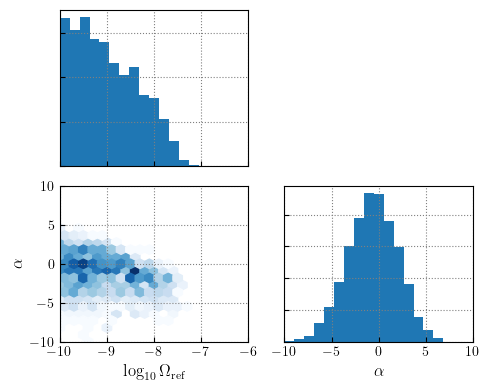

In [17]:
# Extract samples and plot!
data = az.from_numpyro(mcmc)
posterior = az.extract(data,var_names=['log_Omega','alpha'])

fig,axs = plt.subplots(2,2,figsize=(5,4))

axs[0,0].hist(posterior.log_Omega.values,bins=np.linspace(-10,-6,20))
axs[0,0].set_xlim(-10,-6)
axs[0,0].set_xticklabels([])
axs[0,0].set_yticklabels([])

axs[1,1].hist(posterior.alpha.values,bins=np.linspace(-10,10,20))
axs[1,1].set_xlim(-10,10)
axs[1,1].set_yticklabels([])
axs[1,1].set_xlabel(r'$\alpha$')

axs[1,0].hexbin(posterior.log_Omega.values,posterior.alpha.values,
                gridsize=20,extent=(-10,-6,-10,10),cmap='Blues',mincnt=1)
axs[1,0].set_xlim(-10,-6)
axs[1,0].set_ylim(-10,10)
axs[1,0].set_xlabel(r'$\log_{10}\Omega_\mathrm{ref}$')
axs[1,0].set_ylabel(r'$\alpha$')

axs[0,1].axis('off')
plt.tight_layout()
plt.show()

In [18]:
# Here's a marginally more complicated broken power-law model
def likelihood_bpl(frequencies,Ys,sigmas):
    
    # Draw parameters from our prior
    log_Omega = numpyro.sample("log_Omega",dist.Uniform(-12,-6))
    alpha1 = numpyro.sample("alpha1",dist.Normal(0,3))
    alpha2 = numpyro.sample("alpha2",dist.Normal(0,3))
    
    # Construct proposed model background
    Omega_f_model = jnp.where(frequencies<25.,
                              10.**log_Omega * (frequencies/25.)**alpha1,
                              10.**log_Omega * (frequencies/25.)**alpha2)
        
    # Compare against data
    # Specifically, this line says that our observations should be distributed as Y ~ N(Omg_f_model,sigma),
    numpyro.sample("obs",dist.Normal(Omega_f_model,sigmas),sample_shape=jnp.shape(frequencies),obs=Ys)
 
# Set up inference and run
kernel = NUTS(likelihood_bpl,dense_mass=True,target_accept_prob=0.98)
mcmc = MCMC(kernel,num_warmup=2000,num_samples=3000,num_chains=1)
rng_key = random.PRNGKey(10)
rng_key,rng_key_ = random.split(rng_key)
mcmc.run(rng_key_,frequencies,Ys,sigmas)
mcmc.print_summary()

sample: 100%|██████████████████████████████████████████████████████████████████| 5000/5000 [00:34<00:00, 145.19it/s, 7 steps of size 1.52e-01. acc. prob=0.98]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha1      0.01      3.02     -0.00     -4.75      4.93   1313.90      1.00
     alpha2     -0.75      2.58     -0.68     -5.06      3.31   1204.93      1.00
  log_Omega    -10.11      1.18    -10.19    -12.00     -8.44   1506.73      1.00

Number of divergences: 0


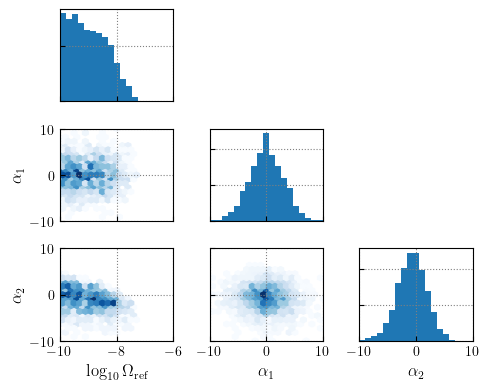

In [19]:
data = az.from_numpyro(mcmc)
posterior = az.extract(data,var_names=['log_Omega','alpha1','alpha2'])

fig,axs = plt.subplots(3,3,figsize=(5,4))

axs[0,0].hist(posterior.log_Omega.values,bins=np.linspace(-10,-6,20))
axs[0,0].set_xlim(-10,-6)
axs[0,0].set_xticklabels([])
axs[0,0].set_yticklabels([])

axs[1,1].hist(posterior.alpha1.values,bins=np.linspace(-10,10,20))
axs[1,1].set_xlim(-10,10)
axs[1,1].set_xticklabels([])
axs[1,1].set_yticklabels([])

axs[2,2].hist(posterior.alpha2.values,bins=np.linspace(-10,10,20))
axs[2,2].set_xlim(-10,10)
axs[2,2].set_yticklabels([])
axs[2,2].set_xlabel(r'$\alpha_2$')

axs[1,0].hexbin(posterior.log_Omega.values,posterior.alpha1.values,
                gridsize=20,extent=(-10,-6,-10,10),cmap='Blues',mincnt=1)
axs[1,0].set_xlim(-10,-6)
axs[1,0].set_ylim(-10,10)
axs[1,0].set_xticklabels([])
axs[1,0].set_ylabel(r'$\alpha_1$')

axs[2,0].hexbin(posterior.log_Omega.values,posterior.alpha2.values,
                gridsize=20,extent=(-10,-6,-10,10),cmap='Blues',mincnt=1)
axs[2,0].set_xlim(-10,-6)
axs[2,0].set_ylim(-10,10)
axs[2,0].set_xlabel(r'$\log_{10}\Omega_\mathrm{ref}$')
axs[2,0].set_ylabel(r'$\alpha_2$')

axs[2,1].hexbin(posterior.alpha1.values,posterior.alpha2.values,
                gridsize=20,extent=(-10,10,-10,10),cmap='Blues',mincnt=1)
axs[2,1].set_xlim(-10,10)
axs[2,1].set_ylim(-10,10)
axs[2,1].set_xlabel(r'$\alpha_1$')
axs[2,1].set_yticklabels([])

axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,2].axis('off')
plt.tight_layout()
plt.show()